In [1]:
!pip install scikit-learn torch --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00


In [2]:
import pandas as pd

df = pd.read_csv("/content/dataset.csv")
text_data = df['report'].fillna("")
label_cols = [col for col in df.columns if col.startswith("type_")]
labels = df[label_cols].values


In [12]:
# TF-IDF Vectorization + Train-Test Split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(text_data).toarray()

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.3, random_state=42
)


In [13]:
# Training Multi-Label Models
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, f1_score, precision_score

models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "SVM": OneVsRestClassifier(SVC(probability=True)),
    "Perceptron (Online)": OneVsRestClassifier(Perceptron(max_iter=1, tol=None))
}

for name, model in models.items():
    print(f"\n🔹 Training {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Hamming Loss:", hamming_loss(y_test, y_pred))
    print("Micro F1 Score:", f1_score(y_test, y_pred, average='micro', zero_division=0))
    print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro', zero_division=0))
    print("Precision@k (sample avg):", precision_score(y_test, y_pred, average='samples', zero_division=0))



🔹 Training Logistic Regression
Hamming Loss: 0.10714285714285714
Micro F1 Score: 0.8074074074074075
Macro F1 Score: 0.3683403217594143
Precision@k (sample avg): 0.8181089743589745

🔹 Training SVM
Hamming Loss: 0.10130494505494506
Micro F1 Score: 0.8180135718692165
Macro F1 Score: 0.4156259260460941
Precision@k (sample avg): 0.8313301282051283

🔹 Training Perceptron (Online)
Hamming Loss: 0.11607142857142858
Micro F1 Score: 0.7978468899521531
Macro F1 Score: 0.5214919150514848
Precision@k (sample avg): 0.8036858974358976


In [14]:
# PyTorch DNN Model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class DefectDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(DefectDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(DefectDataset(X_test, y_test), batch_size=32)


In [15]:
# DNN Architecture & Training
class MultiLabelDNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_size),
            nn.Sigmoid()
        )

    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelDNN(X_train.shape[1], y_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()


In [16]:
#  Training the DNN
for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 17.9572
Epoch 2, Loss: 11.2116
Epoch 3, Loss: 9.8907
Epoch 4, Loss: 8.7864
Epoch 5, Loss: 7.3289
Epoch 6, Loss: 5.5064
Epoch 7, Loss: 3.8412
Epoch 8, Loss: 2.8686
Epoch 9, Loss: 2.0453
Epoch 10, Loss: 1.7476


In [17]:
# Evaluate DNN
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = model(xb).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("\n📊 DNN Evaluation Metrics")
print("Hamming Loss:", hamming_loss(all_labels, all_preds))
print("Micro F1:", f1_score(all_labels, all_preds, average='micro'))
print("Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("Precision@k (samples):", precision_score(all_labels, all_preds, average='samples'))



📊 DNN Evaluation Metrics
Hamming Loss: 0.09478021978021978
Micro F1: 0.8327272727272728
Macro F1: 0.5204471105889262
Precision@k (samples): 0.8357371794871794


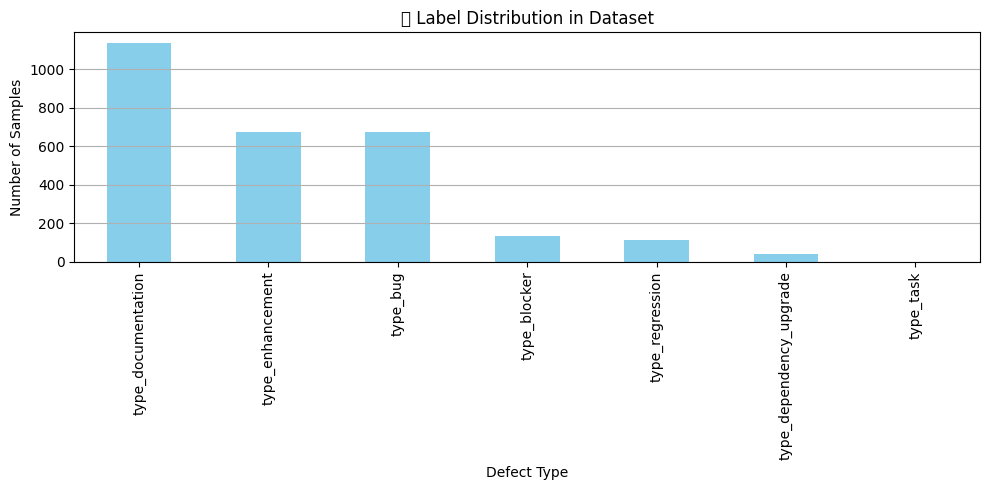

In [18]:
# Label Distribution (Bar Plot)
import matplotlib.pyplot as plt

label_counts = df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("🔍 Label Distribution in Dataset")
plt.xlabel("Defect Type")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


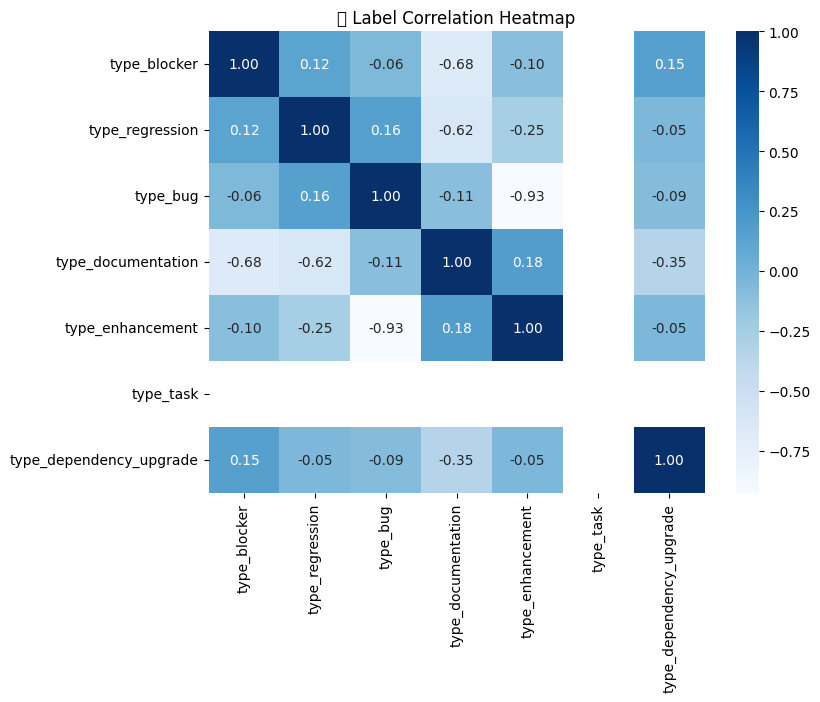

In [19]:
# Correlation Heatmap Between Labels
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df[label_cols].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("📊 Label Correlation Heatmap")
plt.show()
